In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.float32)

from src.data import generate_data, func, add_x_noise
from src.models import BaseNet, MCDropoutNet, SNGPNet, EnsembleNet, SWAGModel, GaussNLLNet, SQRNet, OCNet


torch.manual_seed(42)
import random
random.seed(42)
np.random.seed(42)

## Utility functions

In [2]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def how_many_in_band(y_true, lower, upper):
    return np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size

def calibration_plot_std(y_true, y_pred, std):
    confidence_intervals = []
    for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
        lower = y_pred - i * std
        upper = y_pred + i * std
        confidence_intervals.append([lower, upper])
    calibration_plot(y_true, confidence_intervals)

def calibration_plot(y_true, confidence_intervals):
    quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
    res = []
    for i, it in enumerate(confidence_intervals):
        lower, upper = it
        res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
    print(res)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(quantiles, res, 'ro-', markersize=5)
    lim_lower = 0.8 * min(quantiles[0], res[0])
    lim_upper = 1.05 #1.1 * max(quantiles[-1], res[-1])
    plt.xlim(lim_lower, lim_upper)
    plt.ylim(lim_lower, lim_upper)
    #plt.xticks(quantiles, ['0.5$\sigma$', '$\sigma$', '1.5$\sigma$', '2$\sigma$', '3$\sigma$'], minor=False)
    plt.xlabel('Expected coverage')
    plt.ylabel('Actual coverage')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.gca().set_aspect('equal')
    plt.grid(True)

def plot_results(x_true, y_true, y_pred, y_lower, y_upper, x, y, n_to_plot=1000):
    plt.figure(figsize=(8,4))
    plt.fill_between(x_true, y_lower, y_upper, alpha=0.5)
    plt.plot(x_true, y_true, 'k--')
    plt.plot(x[:n_to_plot], y[:n_to_plot], 'k.', alpha=0.5)
    plt.plot(x_true, y_pred, 'r--', label='pred')
    plt.xlabel('$x$')
    plt.ylabel(r'$f (x + \epsilon_x)$')
    plt.plot(x_true, y_true, 'k--', label='true')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlim(-3, 3)
    plt.show()

## Toy Data Visualization

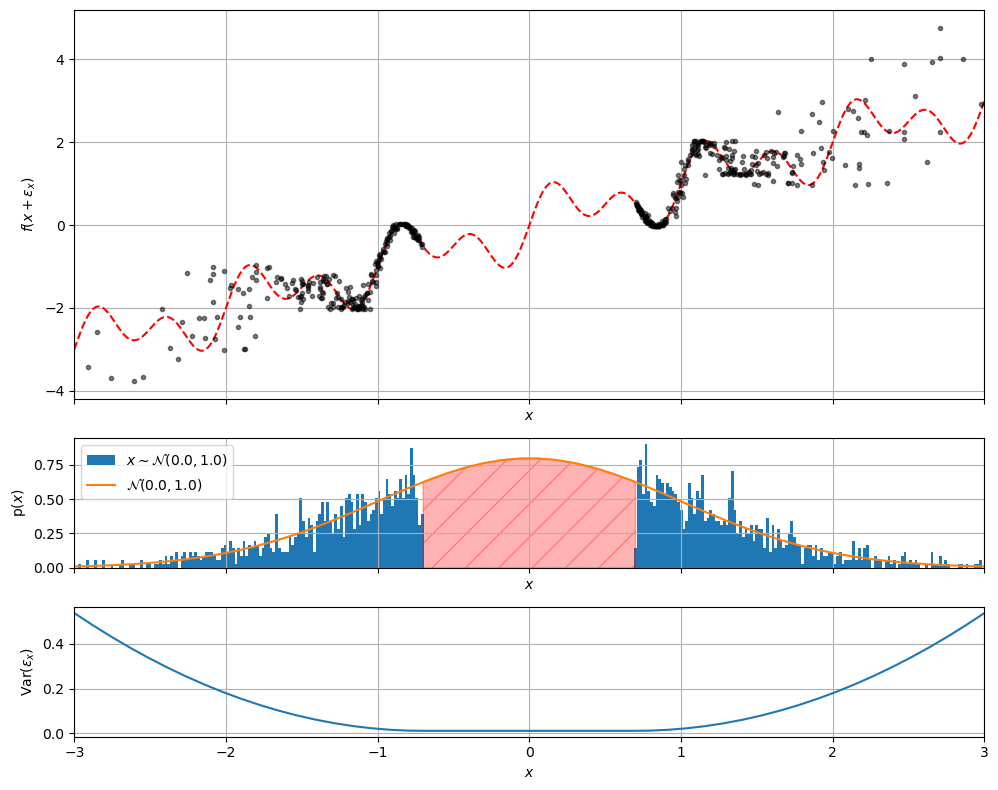

In [3]:
x, y = generate_data()
n_to_plot = 500

exclude = 0.7
fig, axs = plt.subplots(3, 1, sharex='col', gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(10,8))
#plt.figure(figsize=(8,4))
x_true = np.linspace(-3, 3, 1000)
x_true_t = torch.from_numpy(x_true).float().reshape((-1, 1))
x_noisy = add_x_noise(x_true, seed=4242)
x_noisy_t = torch.from_numpy(x_noisy).float().reshape((-1, 1))
y_true = func(x_true)
axs[0].plot(x_true, y_true, 'r--')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel(r'$f (x + \epsilon_x)$')

axs[0].plot(x[:n_to_plot], y[:n_to_plot], 'k.', alpha=0.5)
axs[1].hist(x, bins=400, density=True, label=r'$x \sim \mathcal{N}(0.0, 1.0)$')
x_pdf = 2*np.exp(-0.5*np.linspace(-3, 3)**2)/np.sqrt(2*np.pi)
axs[1].plot(np.linspace(-3, 3), x_pdf, label=r'$\mathcal{N}(0.0, 1.0)$')

var = 0.01  + 0.1 * np.maximum(0, np.abs(np.linspace(-3, 3)) - exclude)**2
axs[1].fill_between(np.linspace(-exclude, exclude), 0.0, 2*np.exp(-0.5*np.linspace(-exclude, exclude)**2)/np.sqrt(2*np.pi), color='red', hatch='/', alpha=0.3)
#axs[1].plot(np.linspace(-3, 3), x_pdf-np.sqrt(var), 'k--', label='noise std')
#axs[1].plot(np.linspace(-3, 3), x_pdf+np.sqrt(var), 'k--')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel(r'p$(x)$')

axs[2].plot(np.linspace(-3, 3), var)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel(r'Var$(\epsilon_x)$')

axs[2].set_xlim(-3, 3)
for ax in axs:
    ax.grid(True)
fig.tight_layout()

### Baseline Model

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 999, prev. loss 0.207: 100%|██████████| 1000/1000 [00:19<00:00, 50.22it/s]


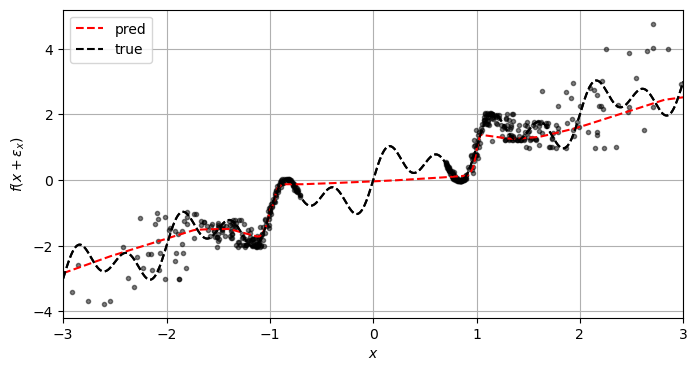

MSE-Loss: 0.4269967518691739


In [4]:
net = BaseNet(p_dropout=0.1)
net.train_model(epochs=1_000)
net.eval()

y_pred = net(x_true_t)
y_pred = y_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(8,4))
plt.plot(x_true, y_true, 'k--')
plt.plot(x[:n_to_plot], y[:n_to_plot], 'k.', alpha=0.5)
plt.plot(x_true, y_pred, 'r--', label='pred')
plt.xlabel('$x$')
plt.ylabel(r'$f (x + \epsilon_x)$')
plt.plot(x_true, y_true, 'k--', label='true')
plt.grid(True)
plt.legend(loc='upper left')
plt.xlim(-3, 3)
plt.show()

y_pred = net(x_noisy_t).detach().cpu().numpy().squeeze()
print(f"MSE-Loss: {mse(y_pred, y_true)}")

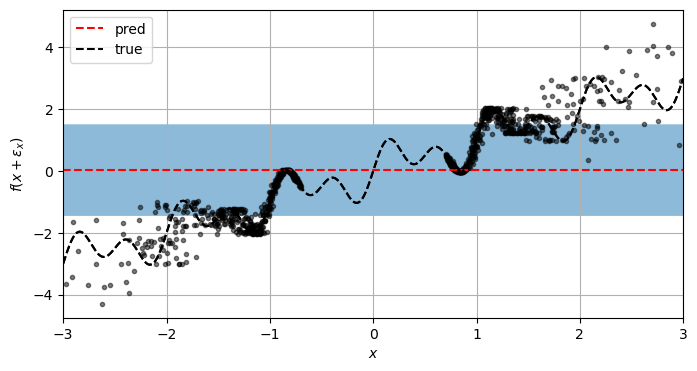

MSE-Loss: 3.0180220311690418
σ-coverage: 0.495
[0.244, 0.495, 0.737, 0.972, 1.0]


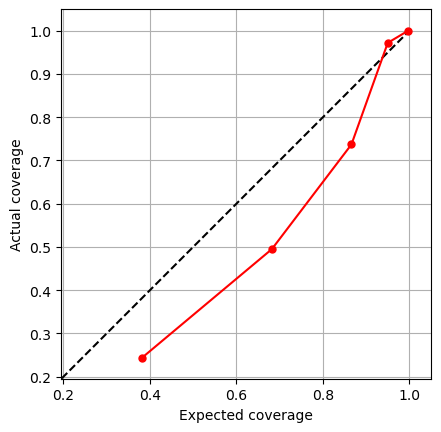

In [5]:
y_pred, y_var = np.ones_like(x_true) * np.mean(y), np.ones_like(x_true) * np.var(y)

y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = np.ones_like(x_noisy) * np.mean(y), np.ones_like(x_noisy) * np.var(y)
y_std = np.sqrt(y_var)


print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

# Determistic Estimation of Uncertainty

Nix, D.A., and A.S. Weigend. “Estimating the Mean and Variance of the Target Probability Distribution.” In Proceedings of 1994 IEEE International Conference on Neural Networks (ICNN’94), 1:55–60 vol.1, 1994. https://doi.org/10.1109/ICNN.1994.374138.

Epoch 999, prev. loss -0.530: 100%|██████████| 1000/1000 [00:19<00:00, 50.16it/s]


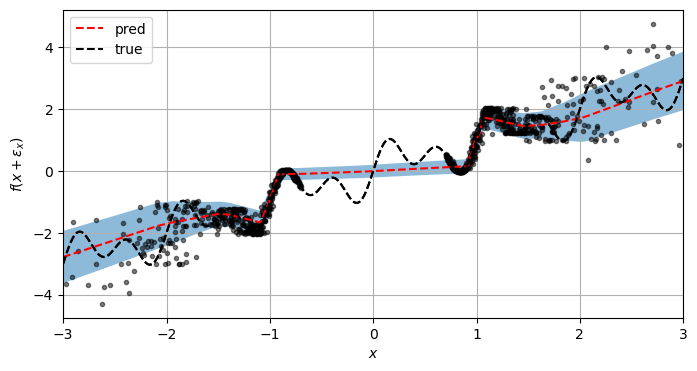

MSE-Loss: 0.4452800563492324
σ-coverage: 0.561
[0.274, 0.561, 0.687, 0.76, 0.865]


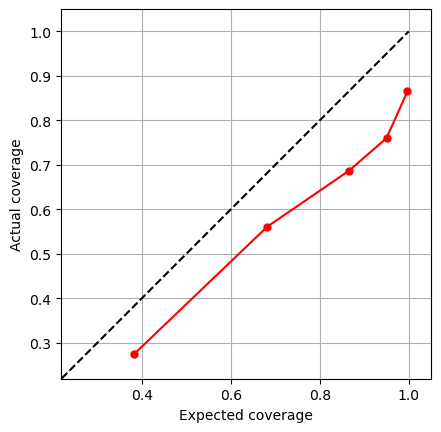

In [6]:
net = GaussNLLNet(p_dropout=0.1)
net.train_model(epochs=1_000)
net.eval()

y_pred, y_var = net(x_true_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()

y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

### Simultaneous Quantile Regression + Orthogonal Certificates (2019)

Epoch 999, prev. loss 0.126: 100%|██████████| 1000/1000 [00:20<00:00, 49.54it/s]


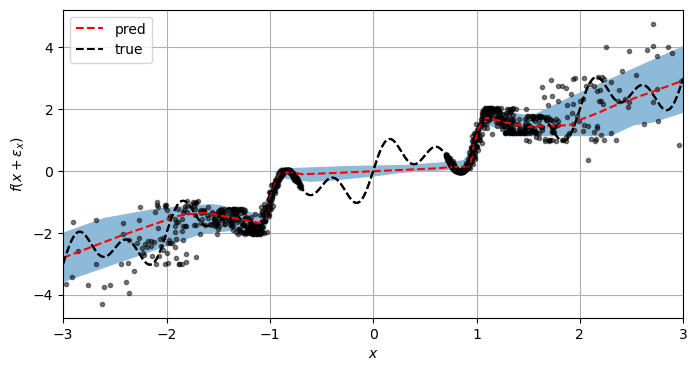

MSE-Loss: 0.4798268282177285
σ-coverage: 0.638
[0.365, 0.638, 0.757, 0.782, 0.8]


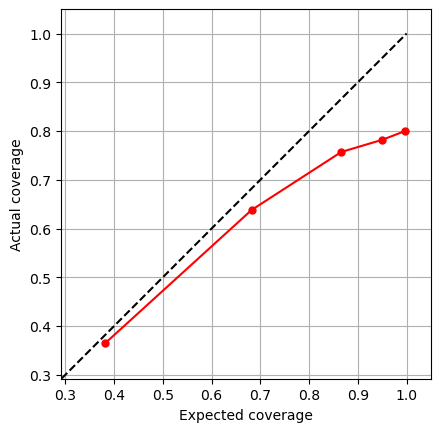

In [7]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
net = SQRNet(p_dropout=0.1)
net.train_model(epochs=1_000)
net.eval()

y_pred, y_lower, y_upper = (
    net(x_true_t, tau=0.5).detach().cpu().numpy().squeeze(),
    net(x_true_t, tau=0.5 - 0.68/2).detach().cpu().numpy().squeeze(),
    net(x_true_t, tau=0.5 + 0.68/2).detach().cpu().numpy().squeeze()
)

plot_results(x_true, y_true, y_pred, y_lower, y_upper, x, y)

y_pred = net(x_noisy_t, tau=0.5).detach().cpu().numpy().squeeze()
confidence_intervals = []
for t in quantiles:
    y_lower, y_upper = (
        net(x_true_t, tau=0.5 - t/2).detach().cpu().numpy().squeeze(),
        net(x_true_t, tau=0.5 + t/2).detach().cpu().numpy().squeeze()
    )
    confidence_intervals.append([y_lower, y_upper])

print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, confidence_intervals[1][0], confidence_intervals[1][1])}")
calibration_plot(y_true, confidence_intervals)

Epoch 999, prev. loss 0.216: 100%|██████████| 1000/1000 [00:19<00:00, 52.31it/s]


Finished training certificates
Certificate loss 3.398
MSE-Loss: 0.23389558561216522


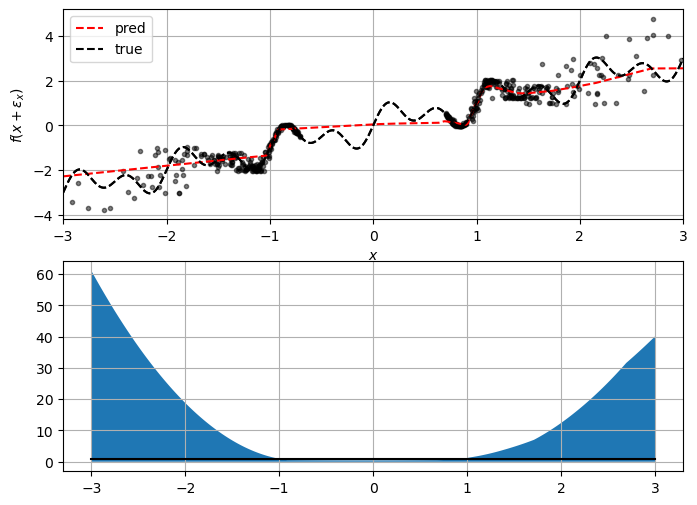

In [11]:
net = OCNet(p_dropout=0.1, _lambda=10.)
net.train_model(epochs=1_000)
net.eval()

expected_response = net.expected_response.detach().cpu().numpy().squeeze()
y_pred, certificate_response = net(x_true_t, return_certificate_response=True)
certificate_response = torch.sum(certificate_response**2, axis=-1)
y_pred, certificate_response = y_pred.detach().cpu().numpy().squeeze(), certificate_response.detach().cpu().numpy().squeeze()

fig, axs = plt.subplots(2, 1, figsize=(8,6))

axs[0].plot(x_true, y_true, 'k--')
axs[0].plot(x[:n_to_plot], y[:n_to_plot], 'k.', alpha=0.5)
axs[0].plot(x_true, y_pred, 'r--', label='pred')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel(r'$f (x + \epsilon_x)$')
axs[0].plot(x_true, y_true, 'k--', label='true')
axs[0].grid(True)
axs[0].legend(loc='upper left')
axs[0].set_xlim(-3, 3)

axs[1].fill_between(x_true, 0, certificate_response/ expected_response, label='Response/Expected Response')
axs[1].plot([-3, 3], [1, 1], 'k-')
axs[1].grid(True)
print(f"MSE-Loss: {mse(y_pred, y_true)}")

## MC Dropout (2016)

Gal, Yarin, and Zoubin Ghahramani. “Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning.” arXiv, October 4, 2016. https://doi.org/10.48550/arXiv.1506.02142.

Epoch 999, prev. loss 0.657: 100%|██████████| 1000/1000 [00:18<00:00, 53.56it/s]


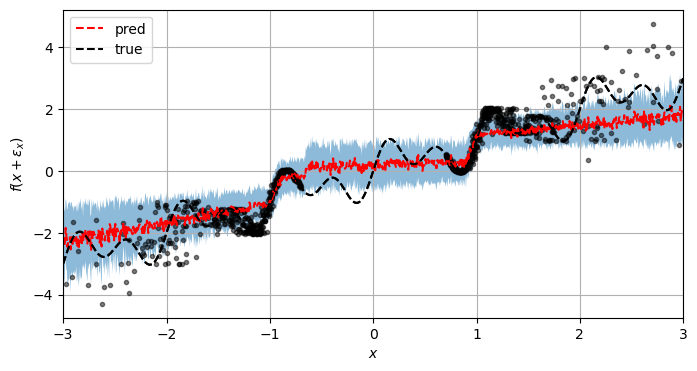

MSE-Loss: 0.4521304076640862
σ-coverage: 0.682
[0.403, 0.682, 0.857, 0.936, 0.992]


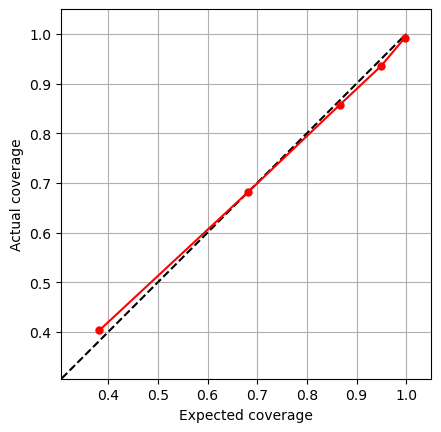

In [12]:
net = MCDropoutNet(p_dropout=0.5)
net.train_model(epochs=1000)
net.eval()

y_pred, y_var = net(x_true_t, return_var=True, n=50)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_true = func(x_true)
y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t, return_var=True, n=50)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)


print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

### Effects of hyperparameters on MC Dropout

Epoch 999, prev. loss 0.629: 100%|██████████| 1000/1000 [00:19<00:00, 51.62it/s]


Text(0, 0.5, 'mse')

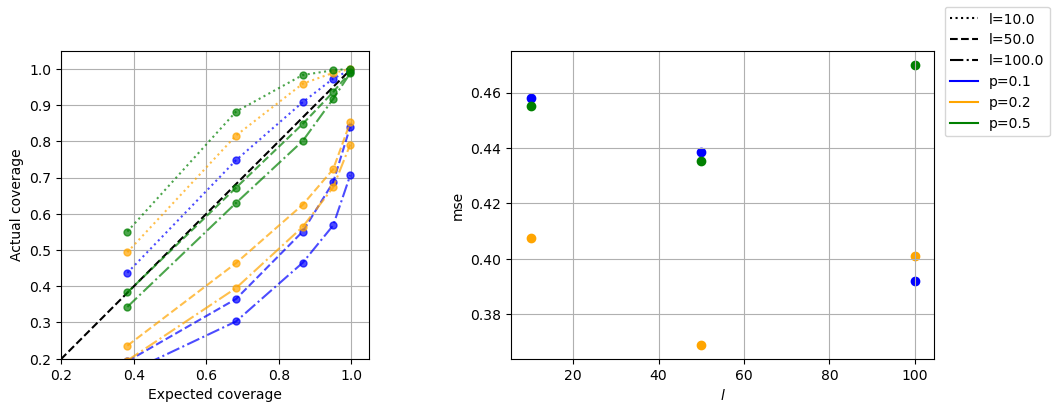

In [13]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot([0, 1], [0, 1], 'k--')
for style, l in zip(['dotted', 'dashed', 'dashdot'],[10., 50., 100.]):
    axs[0].plot([], [], color='k', linestyle=style, label=f'l={l}')
for color, p_dropout in zip(['blue', 'orange', 'green'], [0.1, 0.2, 0.5]):
    axs[0].plot([], [], color=color, label=f'p={p_dropout}')
    for style, l in zip(['dotted', 'dashed', 'dashdot'],[10., 50., 100.]):
        net = MCDropoutNet(p_dropout=p_dropout, l=l)
        net.train_model(epochs=1000)
        net.eval()

        y_pred, y_var = net(x_noisy_t, return_var=True, n=50)
        y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
        y_std = np.sqrt(y_var)
        
        axs[1].scatter([l], [mse(y_pred, y_true)], c=color)

        confidence_intervals = []
        for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
            lower = y_pred - i * y_std
            upper = y_pred + i * y_std
            confidence_intervals.append([lower, upper])

        res = []
        for i, it in enumerate(confidence_intervals):
            lower, upper = it
            res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
        
        axs[0].plot(quantiles, res, alpha=0.7, color=color, linestyle=style)
        axs[0].plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05 

fig.legend(loc='outside upper right')
axs[0].set_xlim(lim_lower, lim_upper)
axs[0].set_ylim(lim_lower, lim_upper)
axs[0].set_xlabel('Expected coverage')
axs[0].set_ylabel('Actual coverage')
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[1].grid(True)
axs[1].set_xlabel('$l$')
axs[1].set_ylabel('mse')


## Deep Ensembles

Lakshminarayanan, Balaji, Alexander Pritzel, and Charles Blundell. “Simple and Scalable Predictive Uncertainty Estimation Using Deep Ensembles.” arXiv, November 3, 2017. https://doi.org/10.48550/arXiv.1612.01474.

### Naive Ensemble

	Training net 1 of 5.


Epoch 999, prev. loss 0.211: 100%|██████████| 1000/1000 [00:19<00:00, 52.41it/s]


	Training net 2 of 5.


Epoch 999, prev. loss 0.214: 100%|██████████| 1000/1000 [00:18<00:00, 54.52it/s]


	Training net 3 of 5.


Epoch 999, prev. loss 0.207: 100%|██████████| 1000/1000 [00:18<00:00, 53.09it/s]


	Training net 4 of 5.


Epoch 999, prev. loss 0.215: 100%|██████████| 1000/1000 [00:18<00:00, 53.44it/s]


	Training net 5 of 5.


Epoch 999, prev. loss 0.209: 100%|██████████| 1000/1000 [00:18<00:00, 54.79it/s]


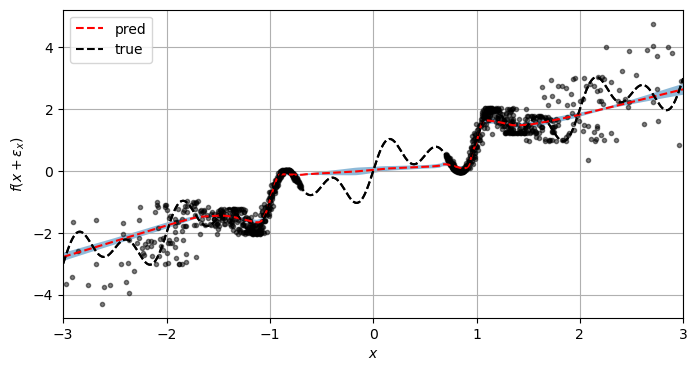

MSE-Loss: 0.3954932694242755
σ-coverage: 0.095
[0.054, 0.095, 0.143, 0.204, 0.321]


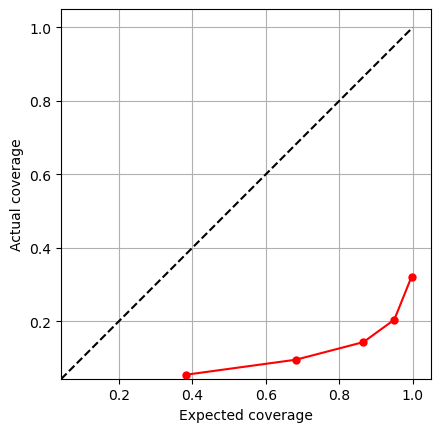

In [14]:
net = EnsembleNet(base_net=BaseNet, base_kwargs=dict(p_dropout=0.1))
net.train_model(epochs=1000)
net.eval()

y_pred, y_var = net(x_true_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()

y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

### Ensemble with proper scoring rules

	Training net 1 of 5.


Epoch 999, prev. loss -0.546: 100%|██████████| 1000/1000 [00:20<00:00, 49.37it/s]


	Training net 2 of 5.


Epoch 999, prev. loss -0.604: 100%|██████████| 1000/1000 [00:19<00:00, 50.02it/s]


	Training net 3 of 5.


Epoch 999, prev. loss -0.582: 100%|██████████| 1000/1000 [00:20<00:00, 49.66it/s]


	Training net 4 of 5.


Epoch 999, prev. loss -0.564: 100%|██████████| 1000/1000 [00:20<00:00, 49.94it/s]


	Training net 5 of 5.


Epoch 999, prev. loss -0.489: 100%|██████████| 1000/1000 [00:19<00:00, 51.48it/s]


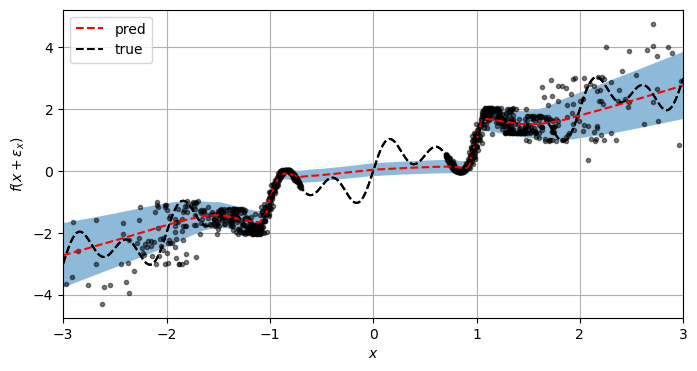

MSE-Loss: 0.3981352401949212
σ-coverage: 0.584
[0.301, 0.584, 0.721, 0.78, 0.888]


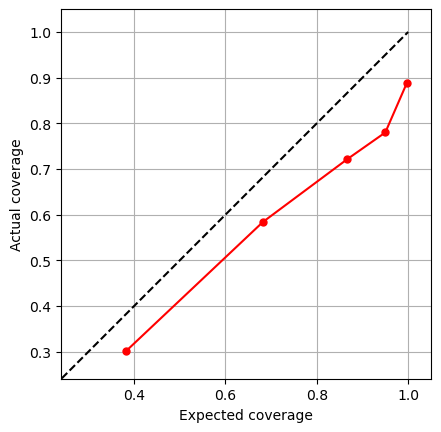

In [15]:
net = EnsembleNet(base_net=GaussNLLNet, base_kwargs=dict(p_dropout=0.1))
net.train_model(epochs=1000)
net.eval()

y_pred, y_var = net(x_true_t, mixture=True)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()

y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t, mixture=True)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

## Stochastic Weight Averaging Gaussian (SWAG)

Maddox, Wesley, Timur Garipov, Pavel Izmailov, Dmitry Vetrov, and Andrew Gordon Wilson. “A Simple Baseline for Bayesian Uncertainty in Deep Learning.” arXiv, December 31, 2019. http://arxiv.org/abs/1902.02476.

Epoch 999, prev. loss 0.159: 100%|██████████| 1000/1000 [00:18<00:00, 55.54it/s]


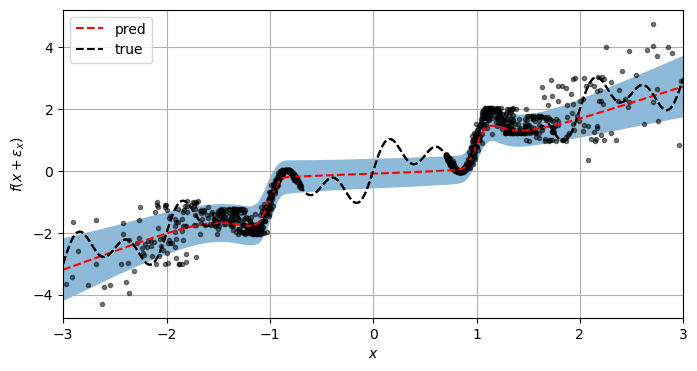

0.44901705444513446
0.568
[0.302, 0.568, 0.761, 0.863, 0.979]


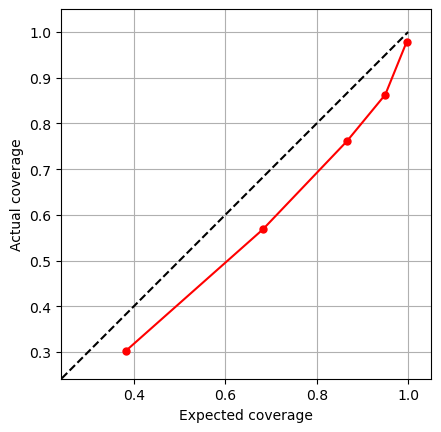

In [25]:

net = SWAGModel()
net.train_model(epochs=1000)
net.eval()

y_pred, y_var = net(x_true_t, return_var=True, n_samples=100)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_true = func(x_true)
y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=100)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(mse(y_pred, y_true))
print(how_many_in_band(y_true, y_pred - y_std, y_pred + y_std))
calibration_plot_std(y_true, y_pred, y_std)

#### How many samples suffice?

Epoch 999, prev. loss 0.161: 100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]


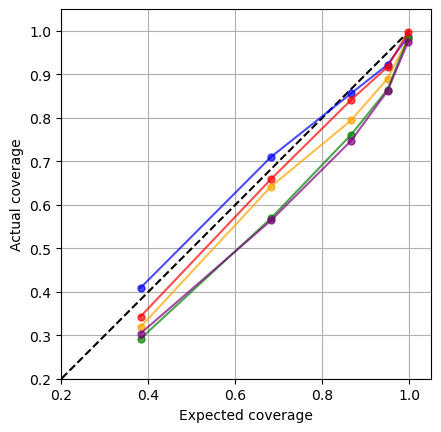

In [51]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
plt.plot([0, 1], [0, 1], 'k--')
net = SWAGModel()
net.train_model(epochs=1000)
net.eval()
for color in ['blue', 'orange', 'green', 'purple', 'red']:
    y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=30)
    y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
    y_std = np.sqrt(y_var)

    confidence_intervals = []
    for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
        lower = y_pred - i * y_std
        upper = y_pred + i * y_std
        confidence_intervals.append([lower, upper])

    res = []
    for i, it in enumerate(confidence_intervals):
        lower, upper = it
        res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
    
    plt.plot(quantiles, res, alpha=0.7, color=color)
    plt.plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05

fig.legend(loc='outside upper right')
plt.xlim(lim_lower, lim_upper)
plt.ylim(lim_lower, lim_upper)
plt.xlabel('Expected coverage')
plt.ylabel('Actual coverage')
plt.gca().set_aspect('equal')
plt.grid(True)


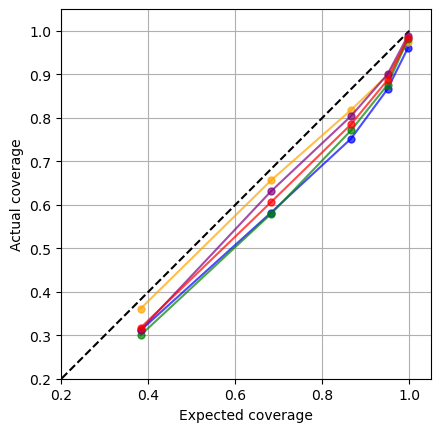

In [52]:
plt.plot([0, 1], [0, 1], 'k--')
for color in ['blue', 'orange', 'green', 'purple', 'red']:
    y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=100)
    y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
    y_std = np.sqrt(y_var)

    confidence_intervals = []
    for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
        lower = y_pred - i * y_std
        upper = y_pred + i * y_std
        confidence_intervals.append([lower, upper])

    res = []
    for i, it in enumerate(confidence_intervals):
        lower, upper = it
        res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
    
    plt.plot(quantiles, res, alpha=0.7, color=color)
    plt.plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05

fig.legend(loc='outside upper right')
plt.xlim(lim_lower, lim_upper)
plt.ylim(lim_lower, lim_upper)
plt.xlabel('Expected coverage')
plt.ylabel('Actual coverage')
plt.gca().set_aspect('equal')
plt.grid(True)


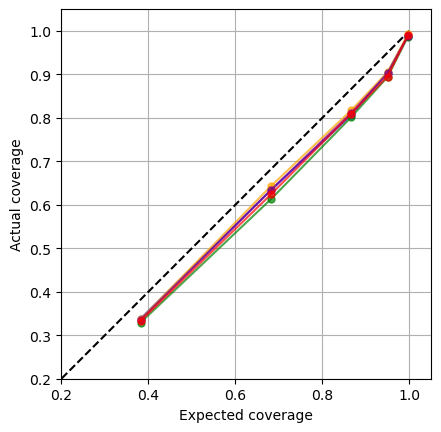

In [53]:
plt.plot([0, 1], [0, 1], 'k--')
for color in ['blue', 'orange', 'green', 'purple', 'red']:
    y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=1000)
    y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
    y_std = np.sqrt(y_var)

    confidence_intervals = []
    for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
        lower = y_pred - i * y_std
        upper = y_pred + i * y_std
        confidence_intervals.append([lower, upper])

    res = []
    for i, it in enumerate(confidence_intervals):
        lower, upper = it
        res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
    
    plt.plot(quantiles, res, alpha=0.7, color=color)
    plt.plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05

fig.legend(loc='outside upper right')
plt.xlim(lim_lower, lim_upper)
plt.ylim(lim_lower, lim_upper)
plt.xlabel('Expected coverage')
plt.ylabel('Actual coverage')
plt.gca().set_aspect('equal')
plt.grid(True)


#### Is coverage stable wrt. hyperparameters?

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 999, prev. loss 0.161: 100%|██████████| 1000/1000 [00:19<00:00, 51.26it/s]


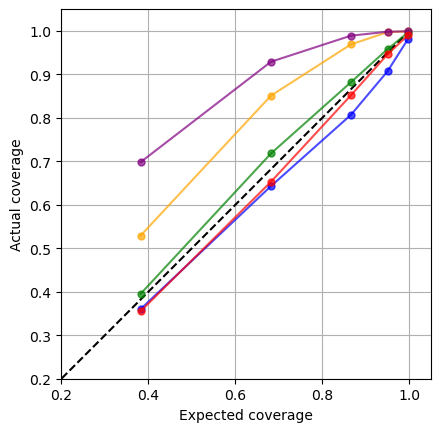

In [54]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
plt.plot([0, 1], [0, 1], 'k--')

for color in ['blue', 'orange', 'green', 'purple', 'red']:
    net = SWAGModel()
    net.train_model(epochs=1000)
    net.eval()
    y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=1000)
    y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
    y_std = np.sqrt(y_var)

    confidence_intervals = []
    for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
        lower = y_pred - i * y_std
        upper = y_pred + i * y_std
        confidence_intervals.append([lower, upper])

    res = []
    for i, it in enumerate(confidence_intervals):
        lower, upper = it
        res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
    
    plt.plot(quantiles, res, alpha=0.7, color=color)
    plt.plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05

fig.legend(loc='outside upper right')
plt.xlim(lim_lower, lim_upper)
plt.ylim(lim_lower, lim_upper)
plt.xlabel('Expected coverage')
plt.ylabel('Actual coverage')
plt.gca().set_aspect('equal')
plt.grid(True)


#### Hyperparameter study

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 999, prev. loss 0.174: 100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s] 


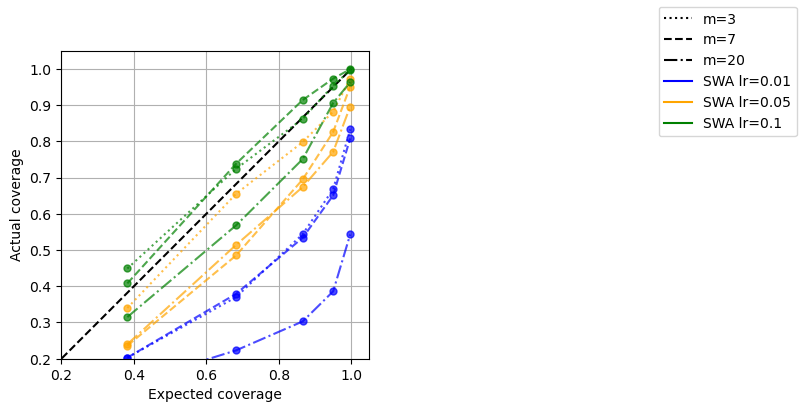

In [59]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
fig, axs = plt.subplots(1, 1, figsize=(12,4))
axs = [axs]
axs[0].plot([0, 1], [0, 1], 'k--')
for style, moment_update_freq in zip(['dotted', 'dashed', 'dashdot'],[3, 7, 20]):
    axs[0].plot([], [], color='k', linestyle=style, label=f'm={moment_update_freq}')
for color, swa_lr in zip(['blue', 'orange', 'green'], [1e-2, 5e-2, 1e-1]):
    axs[0].plot([], [], color=color, label=f'SWA lr={swa_lr}')
    for style, moment_update_freq in zip(['dotted', 'dashed', 'dashdot'],[3, 7, 20]):
        net = SWAGModel()
        net.train_model(epochs=1000, swa_lr=swa_lr, moment_update_freq=moment_update_freq)
        net.eval()

        y_pred, y_var = net(x_noisy_t, return_var=True, n_samples=1000)
        y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
        y_std = np.sqrt(y_var)
        
        #axs[1].scatter([moment_update_freq], [mse(y_pred, y_true)], c=color)

        confidence_intervals = []
        for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
            lower = y_pred - i * y_std
            upper = y_pred + i * y_std
            confidence_intervals.append([lower, upper])

        res = []
        for i, it in enumerate(confidence_intervals):
            lower, upper = it
            res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
        
        axs[0].plot(quantiles, res, alpha=0.7, color=color, linestyle=style)
        axs[0].plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2
lim_upper = 1.05

fig.legend(loc='outside upper right')
axs[0].set_xlim(lim_lower, lim_upper)
axs[0].set_ylim(lim_lower, lim_upper)
axs[0].set_xlabel('Expected coverage')
axs[0].set_ylabel('Actual coverage')
axs[0].set_aspect('equal')
axs[0].grid(True)
#axs[1].grid(True)
#axs[1].set_xlabel('moment update freq')
#axs[1].set_ylabel('mse')


### SWAG with Gaussian NLL

Epoch 999, prev. loss -0.849: 100%|██████████| 1000/1000 [00:18<00:00, 53.21it/s]


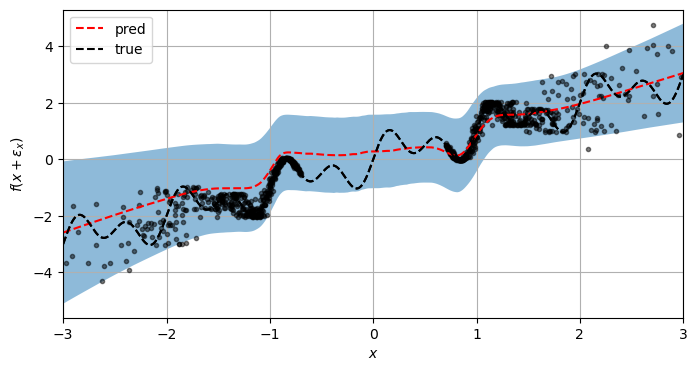

0.5435037177604435
0.859
[0.544, 0.859, 0.966, 0.988, 0.998]


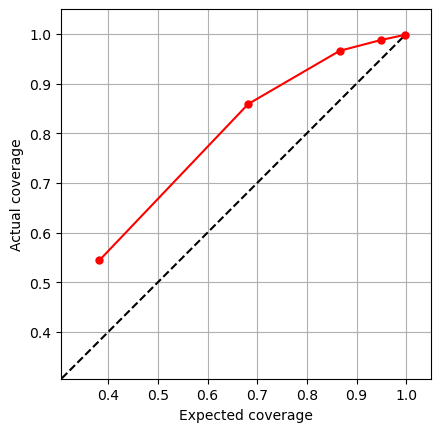

In [42]:
net = SWAGModel(GaussNLLNet)
net.train_model(epochs=1000)
net.eval()

def predict(x, n_samples=100):
    y_means, y_vars = [], []
    for i in range(n_samples):
        net.swag_network.sample(scale=0.5, cov=net.cov_mat)
        mean, var = net.swag_network(x)
        y_means.append(mean)
        y_vars.append(var)
    y_means = torch.stack(y_means)
    y_vars = torch.stack(y_vars)
    y_mean = torch.mean(y_means, axis=0)
    y_var = torch.mean(y_vars + y_means**2, dim=0) - y_mean ** 2
    return y_mean, y_var

y_pred, y_var = predict(x_true_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_true = func(x_true)
y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = predict(x_noisy_t)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(mse(y_pred, y_true))
print(how_many_in_band(y_true, y_pred - y_std, y_pred + y_std))
calibration_plot_std(y_true, y_pred, y_std)

### MultiSWAG

	Training net 1 of 5.


Epoch 999, prev. loss 0.139: 100%|██████████| 1000/1000 [00:17<00:00, 56.00it/s]


	Training net 2 of 5.


Epoch 999, prev. loss 0.139: 100%|██████████| 1000/1000 [00:17<00:00, 56.20it/s]


	Training net 3 of 5.


Epoch 999, prev. loss 0.142: 100%|██████████| 1000/1000 [00:17<00:00, 56.33it/s]


	Training net 4 of 5.


Epoch 999, prev. loss 0.140: 100%|██████████| 1000/1000 [00:17<00:00, 56.17it/s]


	Training net 5 of 5.


Epoch 999, prev. loss 0.141: 100%|██████████| 1000/1000 [00:17<00:00, 56.23it/s]


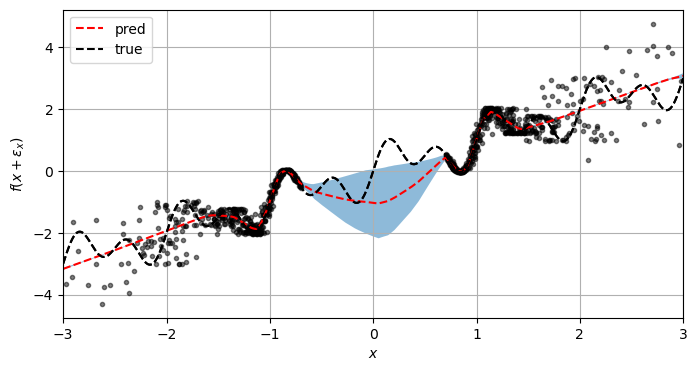

0.573154308981454
0.146
[0.078, 0.146, 0.213, 0.272, 0.332]


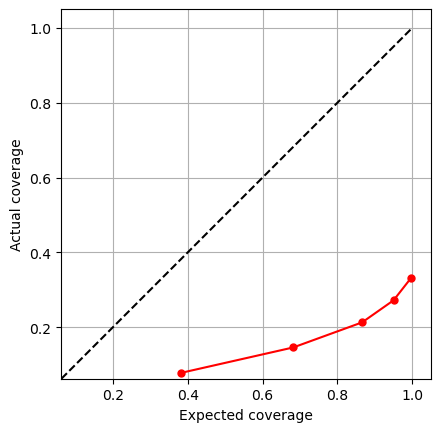

In [43]:
net = EnsembleNet(SWAGModel, base_kwargs=dict())
net.train_model(epochs=1000, swa_lr=2e-5)
net.eval()

y_pred, y_var = net(x_true_t, n_samples=100)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()

y_std = np.sqrt(y_var)

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t, n_samples=100)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(y_var)

print(mse(y_pred, y_true))
print(how_many_in_band(y_true, y_pred - y_std, y_pred + y_std))
calibration_plot_std(y_true, y_pred, y_std)

## Spectral Normalized Gaussian Processes (SNGP)

Liu, Jeremiah Zhe, Zi Lin, Shreyas Padhy, Dustin Tran, Tania Bedrax-Weiss, and Balaji Lakshminarayanan. “Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness.” arXiv, October 25, 2020. https://doi.org/10.48550/arXiv.2006.10108.

Epoch 299, prev. loss 0.197: 100%|██████████| 300/300 [01:19<00:00,  3.77it/s]


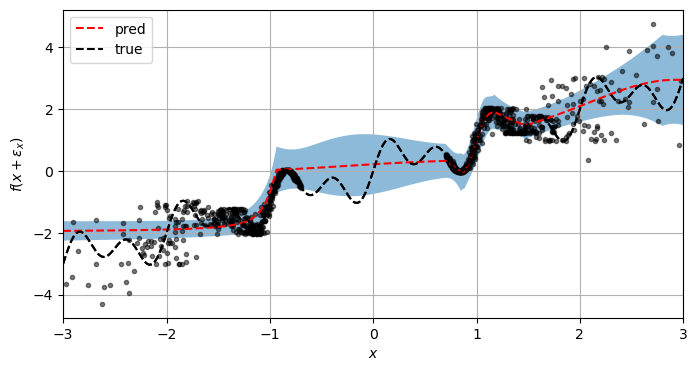

MSE-Loss: 0.3846785415176831
σ-coverage: 0.611
[0.362, 0.611, 0.762, 0.849, 0.948]


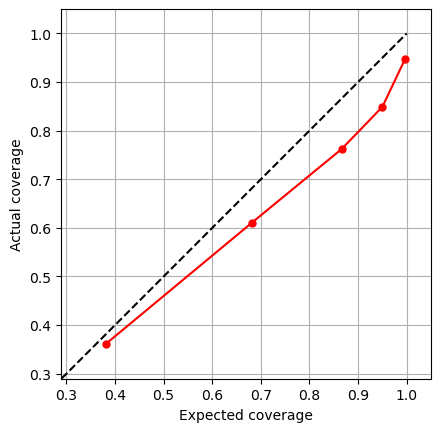

In [46]:
net = SNGPNet()
net.train_model(epochs=300)
net.eval()

y_pred, y_var = net(x_true_t, return_gp_cov=True)

y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()

y_std = np.sqrt(np.diag(y_var))

plot_results(x_true, y_true, y_pred, y_pred - y_std, y_pred + y_std, x, y)

y_pred, y_var = net(x_noisy_t, return_gp_cov=True)
y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
y_std = np.sqrt(np.diag(y_var))

print(f"MSE-Loss: {mse(y_pred, y_true)}")
print(f"σ-coverage: {how_many_in_band(y_true, y_pred - y_std, y_pred + y_std)}")
calibration_plot_std(y_true, y_pred, y_std)

Epoch 999, prev. loss 0.151: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]
/var/folders/r0/12hxq7zs2mx5kr76ks1_n9k80000gn/T/ipykernel_73915/2419239908.py:16: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(np.diag(y_var))
Epoch 999, prev. loss 0.165: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


Text(0, 0.5, 'mse')

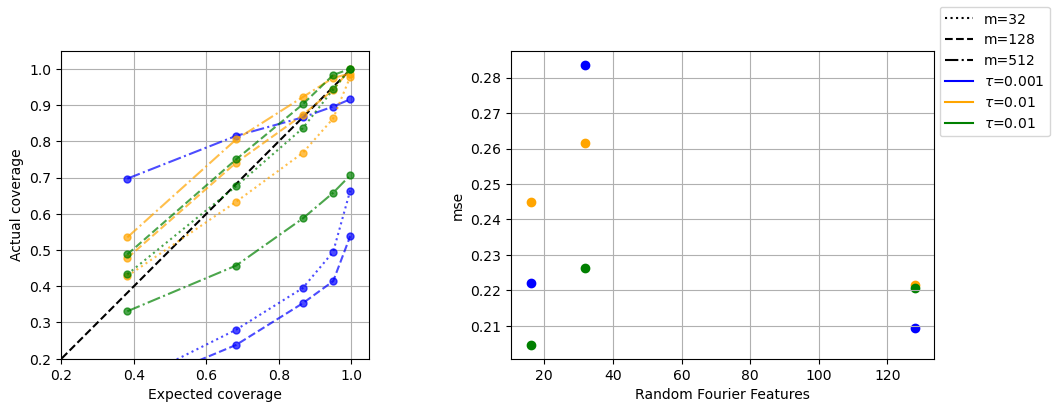

In [47]:
quantiles = [0.382, 0.682, 0.866, 0.95, 0.997]
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot([0, 1], [0, 1], 'k--')
for style, num_rff in zip(['dotted', 'dashed', 'dashdot'],[32, 128, 512]):
    axs[0].plot([], [], color='k', linestyle=style, label=f'm={num_rff}')
for color, ridge_penalty in zip(['blue', 'orange', 'green'], [1e-3, 1e-2, 1e-2]):
    axs[0].plot([], [], color=color, label=f'$\\tau$={ridge_penalty}')
    for style, num_rff in zip(['dotted', 'dashed', 'dashdot'],[16, 32, 128]):
        net = SNGPNet(gp_layer_kwargs=dict(num_inducing=num_rff, gp_cov_ridge_penalty=ridge_penalty))
        net.train_model(epochs=1000)
        net.eval()

        y_pred, y_var = net(x_true_t, return_gp_cov=True)

        y_pred, y_var = y_pred.detach().cpu().numpy().squeeze(), y_var.detach().cpu().numpy().squeeze()
        y_std = np.sqrt(np.diag(y_var))
        
        axs[1].scatter([num_rff], [mse(y_pred, y_true)], c=color)

        confidence_intervals = []
        for i in [0.5, 1.0, 1.5, 2.0, 3.0]:
            lower = y_pred - i * y_std
            upper = y_pred + i * y_std
            confidence_intervals.append([lower, upper])

        res = []
        for i, it in enumerate(confidence_intervals):
            lower, upper = it
            res.append(np.sum((y_true >= lower) & (y_true <=upper)) / y_true.size)
        
        axs[0].plot(quantiles, res, alpha=0.7, color=color, linestyle=style)
        axs[0].plot(quantiles, res, 'o', alpha=0.7, color=color, markersize=5)

lim_lower = 0.2 #0.8 * min(quantiles[0], res[0])
lim_upper = 1.05 #1.1 * max(quantiles[-1], res[-1]) 

fig.legend(loc='outside upper right')
axs[0].set_xlim(lim_lower, lim_upper)
axs[0].set_ylim(lim_lower, lim_upper)
axs[0].set_xlabel('Expected coverage')
axs[0].set_ylabel('Actual coverage')
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[1].grid(True)
axs[1].set_xlabel('Random Fourier Features')
axs[1].set_ylabel('mse')
